## Physics-Informed Neural Networks for Approximating the Solution of the 1D Poisson Equation

#### This code is part of the article "Physics-Informed Neural Networks for Approximating the Solution of the 1D Poisson Equation" , Cabrera Navarrete, E. A., & Díaz Cortés, G. B. (2025). All code was written in Python 3.10, using the libraries Numpy 1.26.4 and Matplotlib 3.9.1.
\
Note: If you use this code in a scientific publication, please cite this work:

Cabrera Navarrete, E. A., & Díaz Cortés, G. B., 2025, "Physics-Informed Neural Networks for Approximating the Solution of the 1D Poisson Equation", Core 2025 congress.

### Case of Study

This notebook contains the implementation of a PINN model to approximate the poisson 1D solution equation, defined as:

$$\frac{d^2u(x)}{dx^2} = 1, \qquad x \in [0,1],$$

where $u$ is the solution to $\frac{d^{2}u}{dx}$, subject to the boundary conditions

$$u(0) = 1, \quad u(1) = 2.$$

The analytical solution is represented by the expresion:

$$u(x) = \frac{1}{2} ({x}^{2}+x) + 1,$$

### Metodology

The goal is to approximate $u$ using a PINN model $\hat{u}(\theta,x)$, where $\theta$ is the set of parameters. This approach involves formulating the loss function $\mathcal{L}$, which incorporates the components of the differential in $\mathcal{L}_{physics}$, the boundary conditions in $\mathcal{L}_{BC}$, and the phenomenon observations in $\mathcal{L}_{data}$.

$$\mathcal{L}(\theta)=\underbrace{\langle{(\hat{u}'' -1)}^{2}\rangle}_{\mathcal{L}_{physics}}+\underbrace{{(\hat{u}(0)-1)}^{2}+{(\hat{u}(1)-2)}^{2}}_{\mathcal{L}_{BC}}+\underbrace{{(\hat{u}_{D}-u_{D})}^{2}}_{\mathcal{L}_{data}},$$

the terms $u''(x)$ and $\hat{u}''(x)$ represent the second derivatives of $u$ and $\hat{u}$ with respect to $x$, respectively. In the case of data loss component $\mathcal{L}_{data}$, $u_{D}$ denotes the known data $u(x_{D})$, while $\hat{u}_{D}$ corresponds to the approximation $\hat{u}(x_{D})$.

In our case, the proposed PINN model is defined by the expression, 

$$\hat{u}(x) = W^{1}_{i} \varphi (W^{0}_{i}x+b^{0}_{i})+b^{1}.$$

The set of parameters $\theta$ is composed by $\{W^{0}_{i},W^{1}_{i},b^{0}_{i},b^{1}\}$, also it is defined $\varphi$ as the activation function. For this case, $\varphi$ is a sigmoid function, defined as:

$$\varphi (\epsilon)= \frac{1}{1+e^{-\epsilon}},\quad \mathbb{R} \rightarrow{}[0,1].$$

To adjust the model parameters during the training phase, a gradient descent algorithm is implemented, represented by 

$$\theta^{k+1} = \theta^{k} - \eta \frac{\partial \mathcal{L}(\theta)}{\partial \mathbf{\theta}}.$$

The function $\mathcal{L}$ is differentiated with respect to each parameter and multiplied by a factor $\eta$, known as the learning rate. Lower $\eta$ values result in precise but slow convergence, whereas higher $\eta$ values lead to faster but less accurate convergence. Therefore, the appropriate $\eta$ value must be determined based on the studied function.

The parameter updates at each iteration $k$ are represented as follows:

$$W^{1, k+1}_{i}=W^{1,k}_{i}+\eta \frac{\partial \mathcal{L}(\theta)}{\partial W^{1}_{i}}, \qquad
    W^{0,k+1}_{i}=W^{0,k}_{i}+\eta \frac{\partial \mathcal{L}(\theta)}{\partial W^{0}_{i}}, \qquad
    b^{1,k+1}=b^{1,k}+\eta \frac{\partial \mathcal{L}(\theta)}{\partial b^{1}}, \qquad b^{0,k+1}_{i}=b^{0,k}_{i}+\eta \frac{\partial \mathcal{L}(\theta)}{\partial b^{0}_{i}}.$$

Furthermore, the terms that constitute the loss function $\mathcal{L}$ are defined as follows:

$$\hat{u}(x) = \sum_{n=1}^{N} W^{1}_{i} \varphi(W^{0}_{i} x + b^{0}_{i}) +b^{1},$$
$$\hat{u}(0) = \sum_{n=1}^{N} W^{1}_{i} \varphi(b^{0}_{i}) +b^{1},$$
$$\hat{u}(1) = \sum_{n=1}^{N} W^{1}_{i} \varphi(W^{0}_{i} + b^{0}_{i}) +b^{1},$$
$$\hat{u}''(x)= \sum_{n=1}^{N} W^{1}_{i} (W^{0}_{i})^{2}\varphi''(W^{0}_{i} x + b^{0}_{i}).$$

### Libraries

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

### Functions
Activation function:
$$\varphi(\epsilon)=\frac{1}{1+e^{-\epsilon}}$$
First derivative of the activation function:
$$\varphi'(\epsilon)=\varphi(\epsilon) (1-\varphi(\epsilon))$$
Second derivative of the activation function:
$$\varphi''(\epsilon)=\varphi'(\epsilon) (1-2\varphi(\epsilon))$$
Third derivative of the activation function:
$$\varphi'''(\epsilon)=\varphi''(\epsilon) (1-2(\varphi(\epsilon)+\varphi'(\epsilon)^{2}))$$
Root Mean Squared Error:
$$RMSE=\sqrt{\sum^{n}_{i} \frac{(u_i-\hat{u}_i)^2}{n}},$$

In [2]:
# Functions
# Analytic Solution
def analytic_solution(x):
    return 0.5 * x ** 2 + 0.5 * x + 1

# Activation function and its derivatives    
def sigmoid(x):
    return (1/(1+np.exp(-x)))
    
def dsigmoid(x):
    return sigmoid(x) * (1-(sigmoid(x)))
    
def ddsigmoid(x):
    return dsigmoid(x) * (1-2*(sigmoid(x)))

def dddsigmoid(x):
    return ddsigmoid(x) * (1 - 2 * sigmoid(x)) - 2 * (dsigmoid(x) ** 2)

# Root Mean Squared Error
def rmse(y1, y2):
    return np.sqrt(((y1-y2)**2).mean())

### PINN function

The following function initializes the PINN parameters and executes the model training. The algorithm describing how this function works is given in the following pseudocode:

$$
\begin{array}{l}
\hline
\textbf{Algorithm: }\text{PINN training}\\
\hline
\text{Set parameters: } \\
Ne \text{ (number of epochs), } Tb \text{ (batch size), } \eta \text{ (learning rate), } \\ 
Nn \text{ (number of neurons), } Tt \text{ (tolerance), } N_{i} \text{ (collocation points). } \\
\text{if data = True then:} \\
\qquad \text{Set } x_{d}, y_{d} \\
\text{Run PINN function: } \\
\qquad \text{Random initialization of }(W_{Nn}, b_{Nn})\\
\qquad \text{For each epoch in } Ne:\\
\qquad \qquad i = 0\\
\qquad \qquad \text{While } i<Tb \text{ and } \mathcal{L} > Tt: \text{Training batch}\\
\qquad \qquad \qquad \text{Calculate:} \\
\qquad \qquad \qquad \mathcal{L}_{physics} = (\hat{u}''-1)^{2}\\
\qquad \qquad \qquad \mathcal{L}_{BC} = (\hat{u}(0)-1)^{2}+(\hat{u}(1)-2)^{2}\\
\qquad \qquad \qquad \mathcal{L}_{data} = (\hat{u}_{D}-u_{D})^{2}\\
\qquad \qquad \qquad \text{Total Loss:} \\
\qquad \qquad \qquad \mathcal{L} = \mathcal{L}_{physics}+ \mathcal{L}_{BC} +\mathcal{L}_{data} \\
\qquad \qquad \qquad \text{Update Parameters:} \\
\qquad \qquad \qquad \theta^{i+1} = \theta^{i} - \eta \nabla_{\theta} \mathcal{L}^{i} \\
\qquad \qquad \qquad i = i + 1\\
\qquad \qquad \text{end}\\
\qquad \text{end}\\
\text{end}\\
\hline
\end{array}
$$

In [3]:
def pinn(Ne = 1000, Tb = 600, lr = 0.002, Nn = 5, Tt = 1e-30, Ni = 20, data = False,
         x = [0], y = [0], f = [0]):
    # ======================================
    # Function inputs
    # --------------------------------------
    # Ne = Number of Epoachs
    # Tb = Number of Data
    # lr = Learning rate
    # Nn = Number of neurons
    # Tt = Threshold
    # Ni = Number of collocation points
    # data = Data informed (True-False)
    # x = Domain points array
    # y = Analytic solution array
    # f = Poisson equation f
    # m = number of data points for training
    # --------------------------------------
    
    # Weight and bias inizalization
    w0 = -2 + 4 * np.random.random(Nn)
    b0 = -2 + 4 * np.random.random(Nn)
    w1 = -2 + 4 * np.random.random(Nn)
    b1 = -2 + 4 * np.random.random(1)
    
    # Loss curve array
    loss = np.zeros([Ne,4])
    m = int(0.25 * Ni)
    
    # Epoach Loop
    for i in range(Ne):
        bi = 0 
        costi = 2 * Tt
        # Tb Loop
        while (bi <= Tb) and (costi > Tt):
            # Index
            index = np.random.randint(Ni)
            # xi
            xi = x[index]
            # yi
            yi = y[index]
            # zi
            z = w0 * xi + b0
            # fi
            fi = f[index]
            
            # u
            u = np.sum(w1 * sigmoid(w0 * xi + b0)) + b1

            # dduddx
            dduddx = np.sum(w1 * (w0 ** 2) * ddsigmoid(z))

            # u0
            u0 = np.sum(w1 * sigmoid(b0)) + b1

            # u1
            u1 = np.sum(w1 * sigmoid(w0 + b0)) + b1

            # dduddx
            dduddxw0 = 2 * (dduddx - fi) * (2 * w0 * w1 * ddsigmoid(z) + w1 * (w0 ** 3) * dddsigmoid(z))
            dduddxw1 = 2 * (dduddx - fi) * ((w0 ** 2) * ddsigmoid(z))
            dduddxb0 = 2 * (dduddx - fi) * (w1 * (w0 ** 2) * dddsigmoid(z))
            dduddxb1 = 0
            
            # du
            duw0 = 2 * (u - yi) * (w1 * xi * dsigmoid(z))
            duw1 = 2 * (u - yi) * (sigmoid(z))
            dub0 = 2 * (u - yi) * (w1 * dsigmoid(z))
            dub1 = 2 * (u - yi)
        
            # du1
            du1w0 = 2 * (u1 - 2) * (w1 * dsigmoid(w0 + b0))
            du1w1 = 2 * (u1 - 2) * (sigmoid(w0 + b0))
            du1b0 = 2 * (u1 - 2) * (w1 * dsigmoid(w0 + b0))
            du1b1 = 2 * (u1 - 2)

            # du0
            du0w0 = 0
            du0w1 = 2 * (u0-1) * (sigmoid(b0))
            du0b0 = 2 * (u0-1) * (w1 * dsigmoid(b0))
            du0b1 = 2 * (u0-1)

            # Partial derivatives
            dLdw0 = dduddxw0 + du1w0 + du0w0
            dLdw1 = dduddxw1 + du1w1 + du0w1
            dLdb0 = dduddxb0 + du1b0 + du0b0
            dLdb1 = du1b1 + du0b1

            costi = np.mean((dduddx - f) ** 2) + (u0 - 1) ** 2 + (u1 - 2) ** 2 
            # Data Loss
            if data == True:
                dLdw0 += duw0
                dLdw1 += duw1
                dLdb0 += dub0
                dLdb1 += dub1
                costi += (u - yi) ** 2
    
            w0 = w0 - lr * dLdw0
            w1 = w1 - lr * dLdw1
            b0 = b0 - lr * dLdb0
            b1 = b1 - lr * dLdb1
            
            bi += 1

        # Physics Loss
        dduddx_ = np.sum(w1 * (w0 ** 2) * ddsigmoid(np.multiply(w0.reshape(-1,1), x.reshape(-1,1).T).T + b0),
               axis=1)
        
        # Loss values
        loss[i,0] = np.mean((dduddx_ - f) ** 2)
        loss[i,1] = ((u0 - 1) ** 2)[0] + ((u1 - 2) ** 2)[0]
        # Data loss values
        if data == True:
            loss[i,2] = ((u - yi) ** 2)[0]
            # Test Loss
            for j in range(m):
                index = np.random.randint(Ni)
                # xi
                xi = x[index]
                # yi
                yi = y[index]
                # ui 
                u = np.sum(w1 * sigmoid(w0 * xi + b0)) + b1
                loss[i,3] += (u - yi)[0] ** 2
    
    # Trained parameters
    parameters = [w0, b0, w1, b1]
    # u approximation using trained parameters
    ue = np.zeros(Ni)
    for i in range(Ni):
        ue[i] = (np.sum(w1 * sigmoid(w0 * x[i] + b0)) + b1)[0]
    # Analytic solution and approximation
    plt.plot(x, ue, 'ro-', mfc='none',label = "PINN Nn = "+str(Nn))
    plt.plot(x, y, 'b-', label = "Analytic solution")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.show()
    return(parameters, loss, ue)

### Analytic solution

In [4]:
# Domain discretization, x and y arrays
Ni = 10
x = np.linspace(0, 1, Ni)
y = analytic_solution(x)
f = np.ones(Ni)

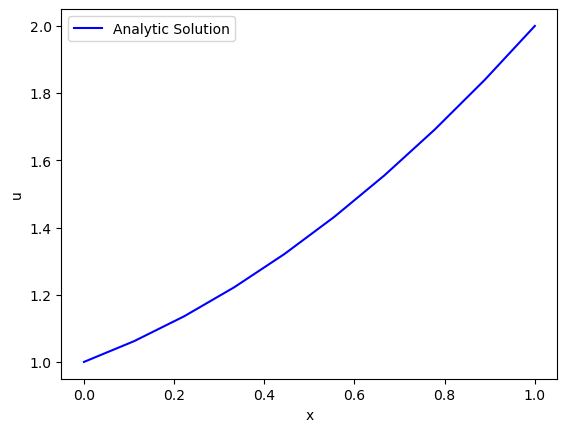

In [5]:
plt.figure()
plt.plot(x, y, "b-", label="Analytic Solution")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()

### Parameter definition and PINN training

The domain discretization is determined by the number of collocation points $(N_{i})$, where $u$ and $\hat{u}$ are computed. The hyperparameters, include the number of neurons $(Nn)$, learning rate $(\eta)$, training epochs $(N_{e})$, and data points used during training $(Tb)$.

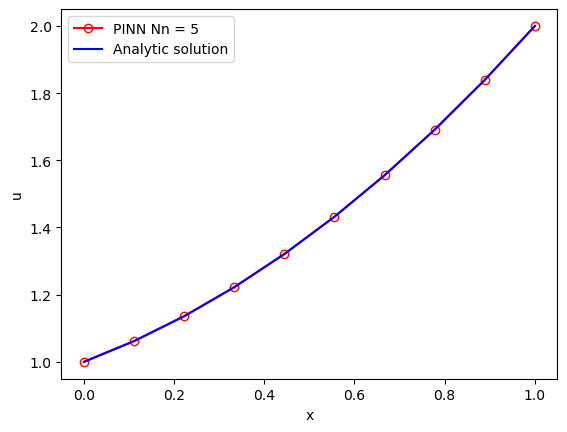

In [6]:
# Parameters
Ne = 1000 # Number of epoachs
Tb = 200  # Batch size
lr = 0.01 # Learning rate
Nn = 5    # Number of neurons

# Run PINN function
parameters, loss, ue = pinn(Ne = Ne, Tb = Tb, lr = lr, Nn = Nn,
                            Ni = Ni, x = x, y = y, f = f, data=True)

### Loss function curves

This plot shows the curves of the loss function.

$$\mathcal{L}=\mathcal{L}_{physics}+\mathcal{L}_{BC}+\mathcal{L}_{data}$$

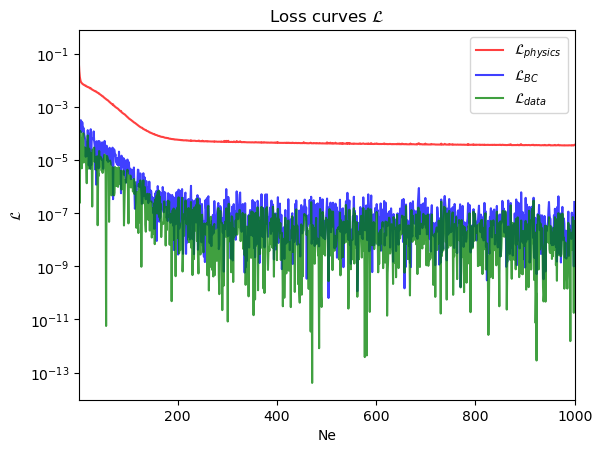

In [7]:
# Colors and labels
colors = ["r","b","g","y"]
labels = ["$\mathcal{L}_{physics}$","$\mathcal{L}_{BC}$",
              "$\mathcal{L}_{data}$","$\mathcal{L}_{Test}$"]

# Loss curves plot for each compoment
plt.figure()
plt.title("Loss curves $\mathcal{L}$")
plt.plot(loss[:,0], c = colors[0], alpha = 0.75, label=labels[0])
plt.plot(loss[:,1], c = colors[1], alpha = 0.75, label=labels[1])
plt.plot(loss[:,2], c = colors[2], alpha = 0.75, label=labels[2])
plt.xlim([1,loss.shape[0]])
plt.yscale("log")
plt.ylabel("$\mathcal{L}$")
plt.xlabel("Ne")
plt.legend()
plt.show()